In [1]:
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from scipy.stats import norm

sys.path.insert(0, '..')
sys.path.insert(0, '../..')
sys.path.insert(0, '../../..')
sys.path.insert(0, '../../../..')

In [2]:
# Load results form .pkl file

output_dir = '../../../../../../../data/Helpdesk/conformal_val/conformal_conformance_results'

filename = os.path.join(output_dir, 'results.pkl')
with open(filename, 'rb') as f:
    loaded_results = pickle.load(f)
print(f"Loaded data from {filename}")

Loaded data from ../../../../../../../data/Helpdesk/conformal_val/conformal_conformance_results/results.pkl


In [3]:
# Data loaded:
# float value
alpha = loaded_results["alpha"]
# dict: prefix length, dict: case name, (List of fitness scores, mean fitness scores, std fitness scores)
case_name_fitness_scores_per_prefix_length = loaded_results["case_name_fitness_scores_per_prefix_length"]
# dict: prefix length, (mean target fitness score, mean most likely fitness score, mean means samples fitness scores)
mean_tgts_ml_samples_per_prefix_length = loaded_results["mean_tgts_ml_samples_per_prefix_length"]
# dict: prefix length, (mean of std within fitness scores, std of mean sampled fitness scores)
std_samples_per_prefix_length = loaded_results["std_samples_per_prefix_length"]
# dict: prefix length, r: sampled fitness score threshold lower bound with 1-alpha coverage.
q_samples_per_prefix_length = loaded_results["q_samples_per_prefix_length"]

Means Target:  [0.91851504 0.91851504 0.91947687 0.84261526 0.80042569 0.77331913
 0.76010101 0.72727273 0.72727273]
Means Most-likely:  [0.94687831 0.95481481 0.93946197 0.85733802 0.80380952 0.77126736
 0.76111111 0.70909091 0.72727273]
Means Means samples:  [0.86478969 0.90430614 0.9040562  0.83217705 0.78407155 0.75516849
 0.74851517 0.70099299 0.71817955]
Total Predictive Uncertainty:  [0.11574871 0.0966975  0.06869645 0.05602106 0.04780809 0.0408722
 0.03413301 0.0347089  0.02566532]
Global Conformal Uncertainty:  [0.07336871 0.07060873 0.09849361 0.08343782 0.08097542 0.0875528
 0.07593582 0.09475089 0.09230076]
Total Predictive and Conformal Uncertainty:  [0.18911742 0.16730624 0.16719007 0.13945887 0.12878351 0.128425
 0.11006883 0.12945979 0.11796608]
r threshold with 1-alpha coverage: [ [0.82625079 0.85007287 0.77072074 0.77205141 0.6982631  0.62455285
 0.65111162 0.6062421  0.62587879] ,  1 ]


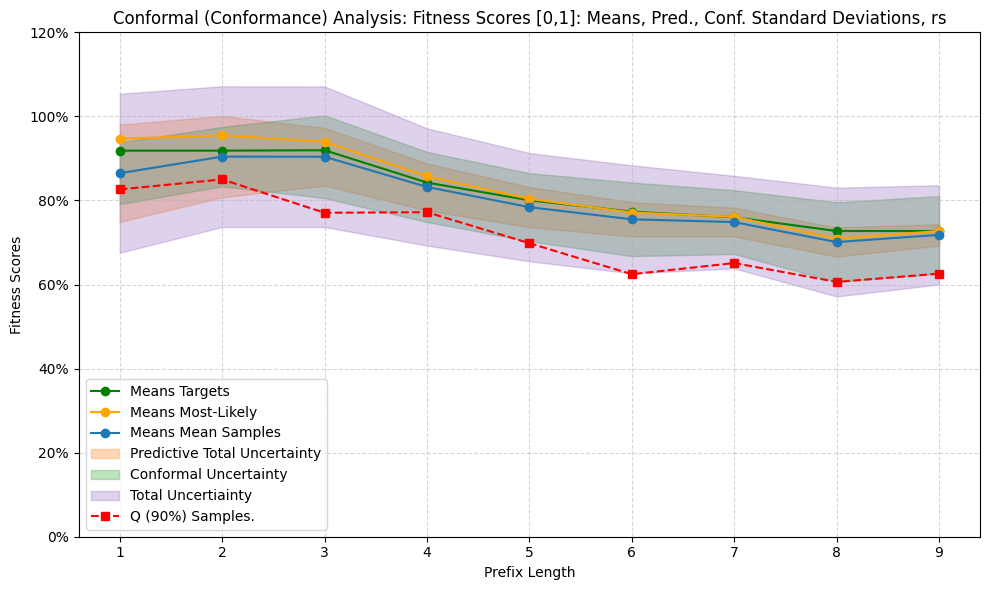

In [ ]:
"""
Visualization of conformal-conformance-analysis:
- Lines of mean fitness values (targte, most-likely, mean of samples) per prefix length as threshold.
- Line for 90% qunatile of mean fitness scores of mean sampled suffix fitness values per prefix length.

- Uncertainty of Probabilistic Suffix Prediction: Mean of ± σ of fitness scores of sample suffixes from a case with the same prefix length.
- Uncertainty of Conformal Predictio: ± σ of all mean fitness score of sample suffixes from a case with the same prefix length.

"""

prefix_lengths = []

means_tgts = []
means_mls = []
means_sms = []

mean_within_std_sm = []
std_between_means_sm = []
total_stds = []

q_samples = []

# iterate over sorted prefix lengths
for prefix_len in sorted(case_name_fitness_scores_per_prefix_length.keys()):
    prefix_lengths.append(prefix_len)

    # extract the three “means” for this prefix
    mean_tgt, mean_ml, mean_samples = mean_tgts_ml_samples_per_prefix_length[prefix_len]
    means_tgts.append(mean_tgt)
    means_mls.append(mean_ml)
    means_sms.append(mean_samples)

    # extract the two std‐values for this prefix
    within_std, between_std = std_samples_per_prefix_length[prefix_len]
    mean_within_std_sm.append(within_std)
    std_between_means_sm.append(between_std)
    
    total_stds.append(within_std + between_std) 

    # extract the conformal q‐threshold for samples
    q_samples.append(q_samples_per_prefix_length[prefix_len])
      
# Sort by prefix (normally already sorted) length and transform to numpy array.
idx = np.argsort(prefix_lengths)

prefix_lengths = np.array(prefix_lengths)[idx]

means_tgts = np.array(means_tgts)[idx]
print("Means Target: ", means_tgts)
means_mls = np.array(means_mls)[idx]
print("Means Most-likely: ", means_mls)
means_sms = np.array(means_sms)[idx]
print("Means Means samples: ", means_sms)

std_probabilistic_suffix_pred = np.array(mean_within_std_sm)
print("Total Predictive Uncertainty: ", std_probabilistic_suffix_pred)
std_conformal = np.array(std_between_means_sm)   
print("Global Conformal Uncertainty: ", std_conformal)
std_total   = np.array(total_stds)  
print("Total Predictive and Conformal Uncertainty: ", std_total) 

q_samples = np.array(q_samples)[idx]
print("r threshold with 1-alpha coverage: ", q_samples)

# Get two-side 1-alpha/2-intervall by using alpha/2:
z90 = norm.ppf(1 - alpha/2) # ≈1.645 for ±90%  

# Build Bounds based on stds
# Std within-band: Probabilistic Suffix Prediction Fitness Score standard deviation:
lower_psp = means_sms - std_probabilistic_suffix_pred
upper_psp = means_sms + std_probabilistic_suffix_pred

# Std between-band: Conformal Calibration
lower_conformal = means_sms - std_conformal
upper_conformal = means_sms + std_conformal

# Total Std
lower_total_std = means_sms -  std_total
upper_total_std = means_sms +  std_total

# Plot
plt.figure(figsize=(10, 6))

# Means:
plt.plot(prefix_lengths, means_tgts, marker='o', label='Means Targets', color='green')
plt.plot(prefix_lengths, means_mls, marker='o', label='Means Most-Likely', color='orange')
plt.plot(prefix_lengths, means_sms, marker='o', label='Means Mean Samples', color='C0')

# Uncertainty (PSP) ± σ:
plt.fill_between(prefix_lengths,
                 lower_psp, 
                 upper_psp,
                 alpha=0.3, color='C1', label='Predictive Total Uncertainty')

# Uncertianty (Conformal Analysis) ± σ
plt.fill_between(prefix_lengths,
                 lower_conformal, 
                 upper_conformal,
                 alpha=0.3, color='C2', label='Conformal Uncertainty')

# Total Uncertianty  ± σ
plt.fill_between(prefix_lengths,
                 lower_total_std, 
                 upper_total_std,
                 alpha=0.3, color='C4', label='Total Uncertiainty')

# Q₀.₉ threshold
plt.plot(prefix_lengths, q_samples, marker='s', linestyle='--', color='red', label='Q (90%) Samples.')

# 6. Polish
plt.xlabel('Prefix Length')
plt.ylabel('Fitness Scores')
plt.ylim(0, 1.2)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(prefix_lengths)  # <--- ensures discrete x-axis ticks
plt.title('Conformal (Conformance) Analysis: Fitness Scores [0,1]: Means, Pred., Conf. Standard Deviations, rs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


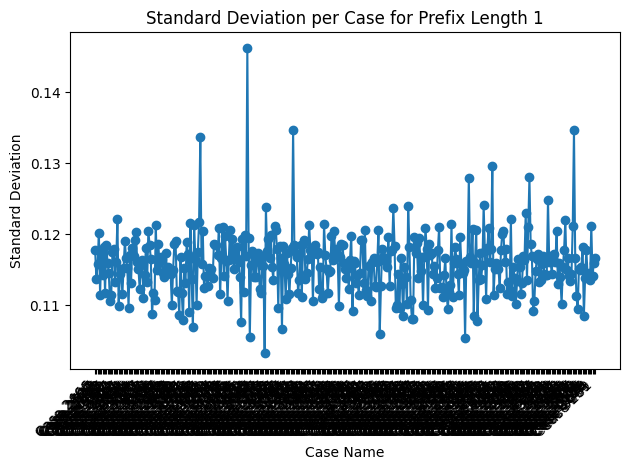

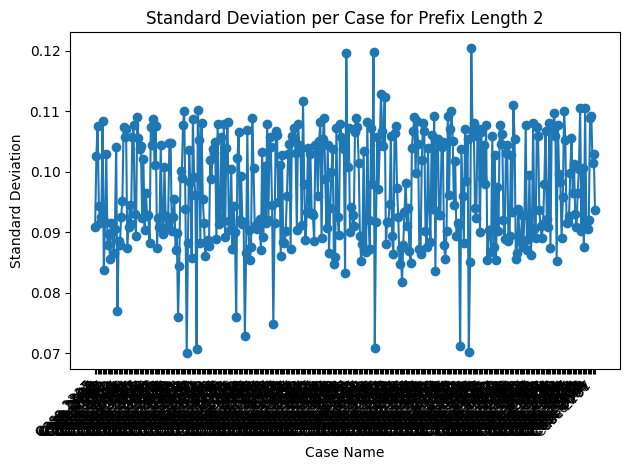

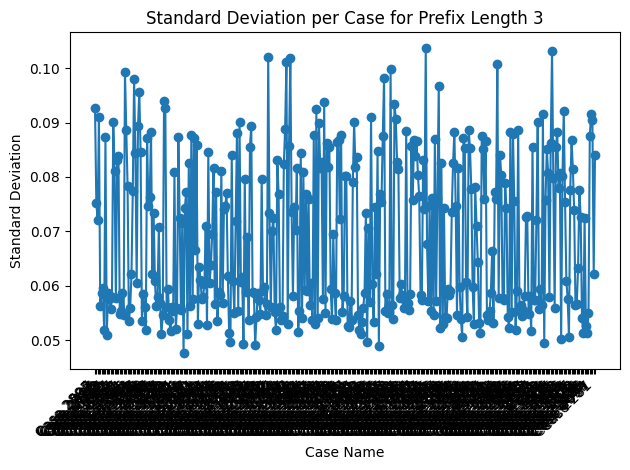

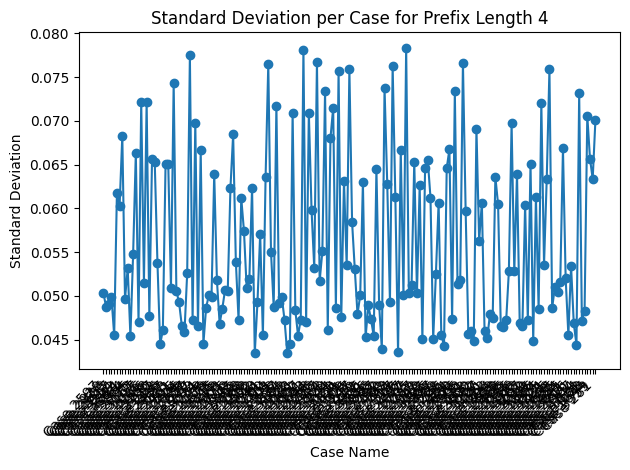

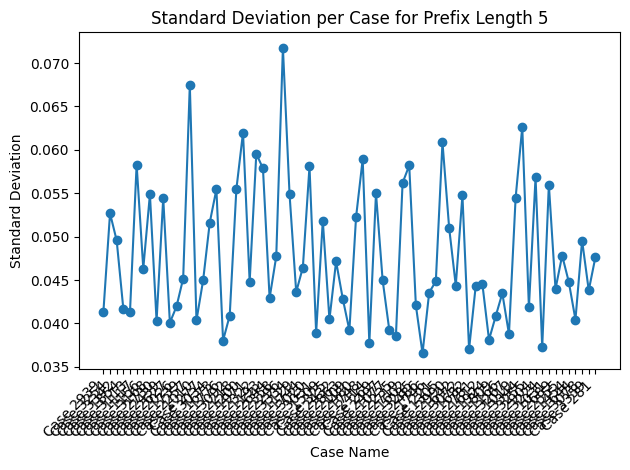

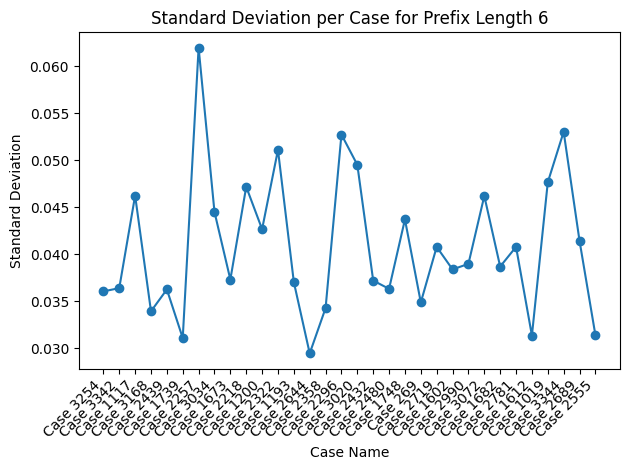

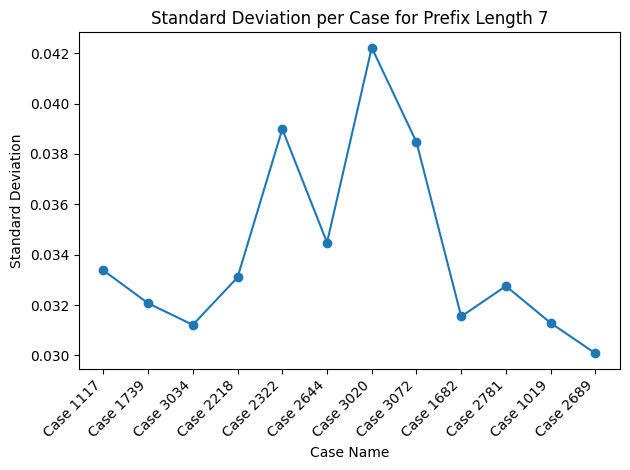

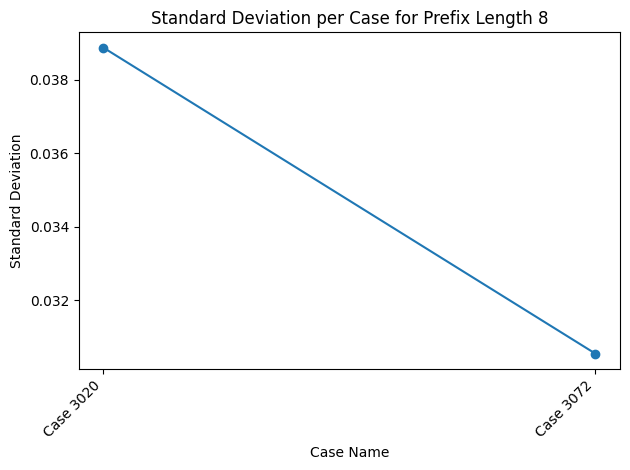

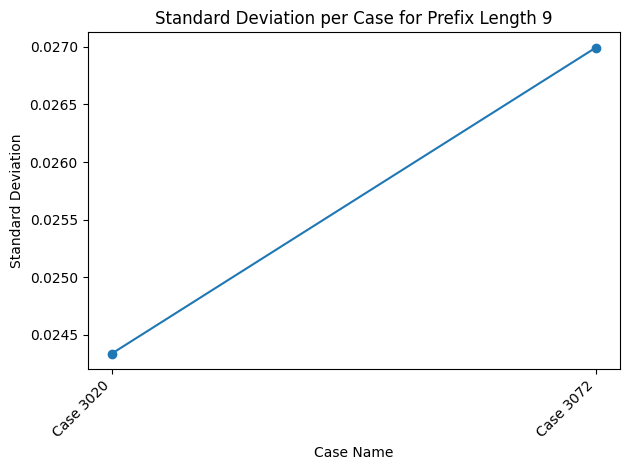

In [5]:
import matplotlib.pyplot as plt

# Assuming `case_name_fitness_scores_per_prefix_length` is defined in the environment,
# where each value is a dict mapping case names to a tuple/list whose third element is the standard deviation.

def plot_std_per_prefix(data_dict):
    for prefix_length, case_dict in data_dict.items():
        case_names = list(case_dict.keys())
        std_per_case = [stats[2] for stats in case_dict.values()]

        plt.figure()
        plt.plot(case_names, std_per_case, marker='o')
        plt.xticks(rotation=45, ha='right')
        plt.xlabel('Case Name')
        plt.ylabel('Standard Deviation')
        plt.title(f'Standard Deviation per Case for Prefix Length {prefix_length}')
        plt.tight_layout()
        plt.show()

# Call the function to generate the plots
plot_std_per_prefix(case_name_fitness_scores_per_prefix_length)
